In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, make_scorer
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from lightgbm import LGBMClassifier
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

In [2]:
# Load the data
df = pd.read_csv('/content/Final_Cleaned.csv')

#imputer = SimpleImputer(strategy='mean', missing_values=np.nan)
#df[['Vit D', 'Calcium']] = imputer.fit_transform(df[['Vit D', 'Calcium']])

#imputer = SimpleImputer(strategy='median', missing_values=np.nan)
#df[['Vit D', 'Calcium']] = imputer.fit_transform(df[['Vit D', 'Calcium']])

# Impute missing values using KNNImputer
imputer = KNNImputer(n_neighbors=5)
df[['Vit D', 'Calcium']] = imputer.fit_transform(df[['Vit D', 'Calcium']])

# Convert categorical variables to numerical using one-hot encoding
data = pd.get_dummies(df, columns=['Gender', 'DM', 'HTN', 'Menopause'])


In [3]:
# Prepare the feature matrix and target vector
X = data.drop(['ID', 'Diagnosis'], axis=1)
y = data['Diagnosis'].map({'Normal': 0, 'Penia': 1, 'Porosis': 2})

# Initialize the LightGBM classifier
clf = LGBMClassifier(random_state=42, max_depth=4)  # Set max_depth to limit tree complexity

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validated predictions
y_pred = cross_val_predict(clf, X, y, cv=cv, method='predict')
y_pred_prob = cross_val_predict(clf, X, y, cv=cv, method='predict_proba')

# Evaluate the model
print("Accuracy:", accuracy_score(y, y_pred))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 381
[LightGBM] [Info] Number of data points in the train set: 327, number of used features: 14
[LightGBM] [Info] Start training from score -1.662826
[LightGBM] [Info] Start training from score -0.665996
[LightGBM] [Info] Start training from score -1.215249
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

AUC for class Normal: 0.9039
AUC for class Penia: 0.7262
AUC for class Porosis: 0.7686
Average AUC: 0.7996


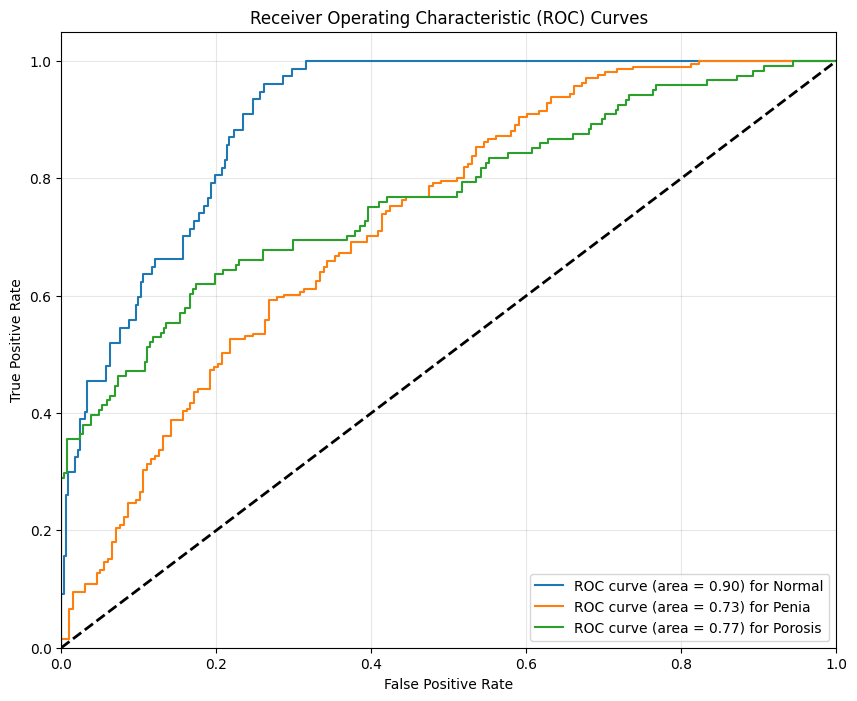

In [4]:
# Binarize the output labels for ROC calculation
y_bin = label_binarize(y, classes=[0, 1, 2])
auc_scores = {}
class_names = ['Normal', 'Penia', 'Porosis']

# Calculate AUC scores for each class
for i, class_name in enumerate(class_names):
    auc = roc_auc_score(y_bin[:, i], y_pred_prob[:, i])
    auc_scores[class_name] = auc
    print(f"AUC for class {class_name}: {auc:.4f}")

# Calculate and print the average AUC
average_auc = np.mean(list(auc_scores.values()))
print(f"Average AUC: {average_auc:.4f}")

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_bin[:, i], y_pred_prob[:, i])
    plt.plot(fpr, tpr, label=f'ROC curve (area = {auc_scores[class_name]:.2f}) for {class_name}')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()